## What is hysetter?
As is describes on the package [Getting Started Page](https://hysetter.readthedocs.io/latest/):

HySetter is an open-source Python package, built on HyRiver software stack, that provides a command-line interface (CLI) and Python API for subsetting hydroclimate data from the following data sources over the conterminous United States (CONUS):

- Area Of Interest: From any HUC level, GAGES-II basins, NHDPlusV2 catchments and their attributes (StreamCat and NLDI), or a user-defined GeoDataFrame
- Drainage Network: From NHDPlusV2
- Forcing: From Daymet, GridMET, or NLDAS2
- Streamflow: From NWIS
- Soil: From gNATSGO, or SoilGrids
- Topography: From 3DEP
- Dam: From NID
- Land Use/Land Cover, Canopy, Imperviousness, and Urban Descriptor: From MRLC

## Installing
You can install using either pip, conda or for just the CLI you can use using an application called pixi

In [1]:
# conda create --name hysetter
# conda install -c conda-forge hysetter

## Basic Usage

### From the command line (CLI) using a config.yml file

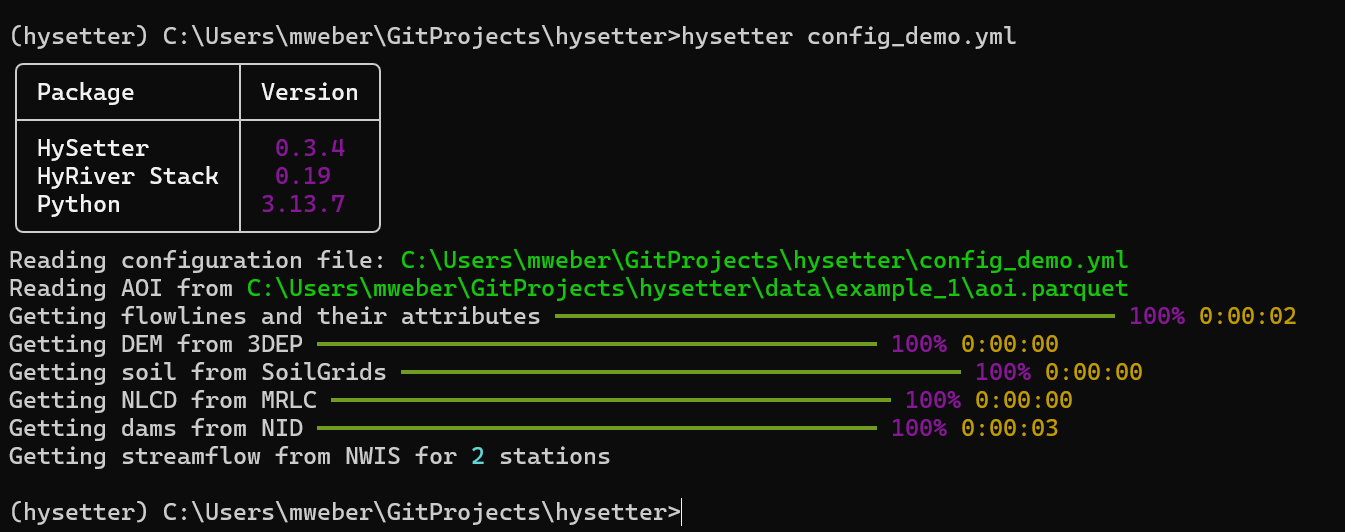

### In Python

#### We use the package API to set up a config file and request data

In [1]:
from __future__ import annotations

import geopandas as gpd
import pandas as pd
import pygeohydro as gh
import utils
import xarray as xr

from hysetter import Config

#### This workflow follows loosely [this example notebook from hysetter docs](https://hysetter.readthedocs.io/latest/examples/ncrspdm/)

In [10]:
config = {
    "project": {"name": "example_2", "data_dir": "data"},
    "aoi": {
        "gagesii_basins": ["01318500", "03335500"],
        "streamcat_attrs": [
            "wetindex",
            "bfi",
            "agkffact",
            "clay",
            "kffact",
            "om",
            "perm",
            "rckdep",
            "sand",
            "wtdep",
            "elev",
        ],
    },
    "soil": {
        "source": "soilgrids",
        "variables": ["bdod_5", "cec_5"],
    },
    "nlcd": {"cover": [2021], "canopy": [2021]},
    "streamflow": {
        "start_date": "2024-01-01",
        "end_date": "2024-12-31",
        "frequency": "daily",
        "use_col": "gage_id",
    },
}

In [11]:
cfg = Config(**config)
cfg.get_data()

Getting AOI: GAGES-II basins from WaterData.
Getting flowlines and their attributes ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:09 50% -:--:--
C:\Users\mweber\.conda\envs\hysetter\Lib\site-packages\pygeohydro\pygeohydro.py:598: FutureWarning: In a future version 
of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to 
lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid
of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  return xr.merge([_read_layer(lyr, valid_depths[d]) for lyr, d in zip(lyr_names, lyr_depths)])
C:\Users\mweber\.conda\envs\hysetter\Lib\site-packages\pygeohydro\pygeohydro.py:598: FutureWarning: In a future version   50% -:--:--
of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to 
lead to different results when combini

In [10]:
geoms = gpd.read_parquet(cfg.file_paths.aoi_parquet)
area_sqm = geoms.to_crs(5070).area.iloc[0]
geoms

,geometry,area,perimeter,gage_id
0,"POLYGON ((-69.67646 45.14558, -69.67636 45.145...",239091000.0,117540,01031450
1,"POLYGON ((-69.67646 45.14558, -69.67636 45.145...",769046000.0,256620,01031500


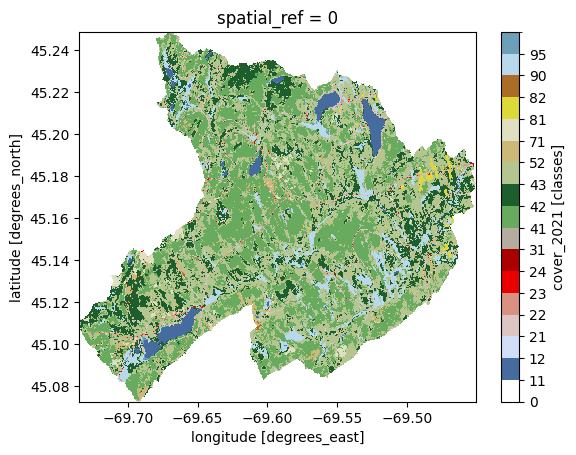

In [5]:
import matplotlib
nlcd = xr.open_dataset('C:/Users/mweber/GitProjects/hysetter/data/example_1/nlcd/nlcd_geom_0.nc')
cmap, norm, levels = gh.cover_legends()
cover = nlcd.cover_2021
_ = cover.plot.imshow(cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})

In [6]:
nlcd_meta = gh.helpers.nlcd_helper()
pd.Series(nlcd_meta["classes"])

11     Open Water - All areas of open water, generall...
12     Perennial Ice/Snow - All areas characterized b...
21     Developed, Open Space - Includes areas with a ...
22     Developed, Low Intensity -Includes areas with ...
23     Developed, Medium Intensity - Includes areas w...
24     Developed, High Intensity - Includes highly de...
31     Barren Land (Rock/Sand/Clay) - Barren areas of...
41     Deciduous Forest - Areas dominated by trees ge...
42     Evergreen Forest - Areas dominated by trees ge...
43     Mixed Forest - Areas dominated by trees genera...
45     Shrub-Forest - Areas identified as currently s...
46     Herbaceous-Forest - Areas identified as curren...
51     Dwarf Scrub - Alaska only areas dominated by s...
52     Shrub/Scrub - Areas dominated by shrubs; less ...
71     Grassland/Herbaceous - Areas dominated by gram...
72     Sedge/Herbaceous - Alaska only areas dominated...
73     Lichens - Alaska only areas dominated by fruti...
74     Moss - Alaska only areas

In [17]:
import pandas as pd
import os
dir_path = 'C:/Users/mweber/GitProjects/hysetter/data/example_2/streamcat_attrs/'

def get_full_file_paths(directory_path):
    """
    Returns a list of full paths for all files within a specified directory
    and its subdirectories using a list comprehension.
    """
    full_file_paths = [
        os.path.join(root, file)
        for root, _, files in os.walk(directory_path)
        for file in files
    ]
    return full_file_paths

file_names = get_full_file_paths(dir_path)
streamcat = pd.read_parquet(file_names)
streamcat.head()

,wetindexcat,agkffactcat,elevcat,omcat,kffactcat,wtdepcat,permcat,bficat,sandcat,claycat,rckdepcat,comid
0,762.3684,0.0000,527.3163,1.910000,0.2100,124.030000,5.590000,52.0000,44.582697,5.420000,108.270000,22305525
1,709.8782,0.0000,577.0837,1.910000,0.2096,124.030000,5.590000,52.0000,44.729958,5.420000,108.270000,22305503
2,625.0738,0.0000,969.5386,0.430000,0.4200,147.900000,9.220000,53.0000,39.640000,7.110000,88.720000,9529649
3,602.4739,0.0000,1069.7602,0.430000,0.4200,147.900000,9.220000,52.9957,39.640000,7.110000,88.720000,9529651
4,784.4417,0.0007,227.6347,0.559401,0.2323,155.768746,22.122913,47.5104,54.547864,4.705229,133.545452,22294818


### Supplying our own geometry for the Area of Interest (aoi) parameter
First we read in and just look at a watershed (headwaters of the Nestucca River) and then add it as a parameter to a new config file for hysetter

['SITE_ID',
 'COMID',
 'WSAREASQKM',
 'PERM_ID',
 'NHDPlusHR_WSAREASQKM',
 'UNIQUE_ID',
 'geometry']

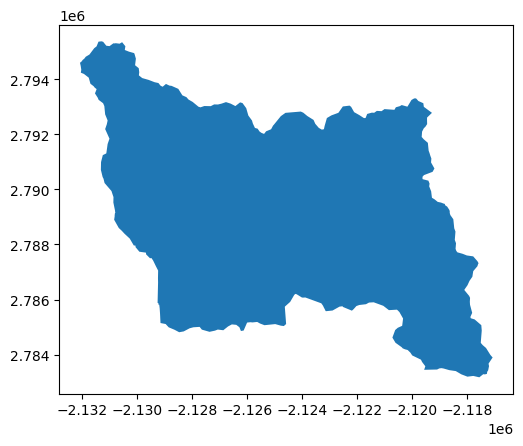

In [30]:
nestucca = gpd.read_file('O:/Priv/CPHEA/PESD/COR/Public/mweber/nestucca.geojson')
nestucca.plot()
list(nestucca)

In [67]:
config = {
    "project": {"name": "nestucca", "data_dir": "data"},
    "aoi": {
        "geometry_file": "O:/Priv/CPHEA/PESD/COR/Public/mweber/nestucca.geojson",
        "streamcat_attrs": [
            "wetindex",
            "rckdep",],
    },
    "soil": {
        "source": "gnatsgo",
        "variables": ['tk0_999a', 'aws0_999'],
    },
}

In [68]:
cfg = Config(**config)
cfg.get_data()

Reading AOI from C:\Users\mweber\GitProjects\hysetter\data\nestucca\aoi.parquet
Getting flowlines and their attributes ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:05
Getting soil from gNATSGO ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00


### Visualize results pulled using hysetter for our watershed

In [51]:
from pynhd import NLDI, WaterData, NHDPlusHR
import pynhd as nhd

We can get either medium or high resolution flowlines for our watershed using `WaterData` in `pynhd` which is part of the `HyRiver` suite of Python packages

In [52]:
hr = NHDPlusHR("flowline")
nhdp_hr = hr.bygeom(nestucca.geometry[0].bounds)

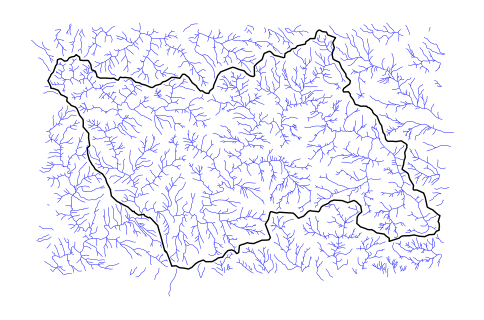

In [53]:
ax = nestucca.plot(figsize=(6, 6), facecolor="none", edgecolor="k")
nhdp_hr.plot(ax=ax, color="b", lw=0.3)
ax.set_axis_off()

We'll use NHDPlus V2 and then we can link and visulualize a few of the attributes we pulled down using `hysetter` for this particular watershed

In [57]:
mr = WaterData("nhdflowline_network")
nhdp_mr = mr.bybox(nestucca.geometry[0].bounds)

In [58]:
nhdp_mr.head()

,geometry,comid,fdate,resolution,gnis_id,gnis_name,lengthkm,reachcode,flowdir,wbareacomi,...,qc_12,vc_12,qe_12,ve_12,lakefract,surfarea,rareahload,rpuid,vpuid,enabled
0,"MULTILINESTRING Z ((-123.39095 45.32434 0, -12...",23796579,2001-02-13T05:00:00Z,Medium,1121647,Haskins Creek,2.307,17090008000055,With Digitized,0,...,89.108,2.05372,78.280,1.98882,NaN,NaN,NaN,17c,17,1
1,"MULTILINESTRING Z ((-123.43704 45.35446 0, -12...",23796581,2001-02-13T05:00:00Z,Medium,1121647,Haskins Creek,5.343,17090008000056,With Digitized,0,...,63.185,2.07577,63.185,2.07577,NaN,NaN,NaN,17c,17,1
2,"MULTILINESTRING Z ((-123.39236 45.30029 0, -12...",23796609,2001-02-13T05:00:00Z,Medium,,,3.584,17090008000070,With Digitized,0,...,44.674,2.08450,44.674,2.08450,NaN,NaN,NaN,17c,17,1
3,"MULTILINESTRING Z ((-123.40179 45.25962 0, -12...",23796669,2001-02-13T05:00:00Z,Medium,1157970,Deer Creek,5.920,17090008000100,With Digitized,0,...,74.988,2.25015,74.988,2.25015,NaN,NaN,NaN,17c,17,1
4,"MULTILINESTRING Z ((-123.41026 45.27055 0, -12...",23796713,2001-02-13T05:00:00Z,Medium,1163356,Willamina Creek,3.545,17090008000122,With Digitized,0,...,33.493,1.91631,33.493,1.91631,NaN,NaN,NaN,17c,17,1


Get NHDPlus catchments to plot and link with the StreamCat metrics we pulled down for the Nestucca basin using `hysetter`

In [69]:
comids = nhdp_mr.comid.to_list()
wd = WaterData("catchmentsp")
catchments = wd.byid("featureid", comids)

streamcat = pd.read_parquet('C:/Users/mweber/GitProjects/hysetter/data/nestucca/streamcat_attrs/streamcat_geom_0.parquet')
soil = pd.read_parquet('C:/Users/mweber/GitProjects/hysetter/data/nestucca/soil/streamcat_geom_0.parquet')
catchments = catchments.merge(streamcat, left_on="featureid", right_on="comid")

In [75]:
list(catchments)

['geometry',
 'gridcode',
 'featureid',
 'sourcefc',
 'areasqkm',
 'shape_length',
 'shape_area',
 'wetindexcat',
 'comid']

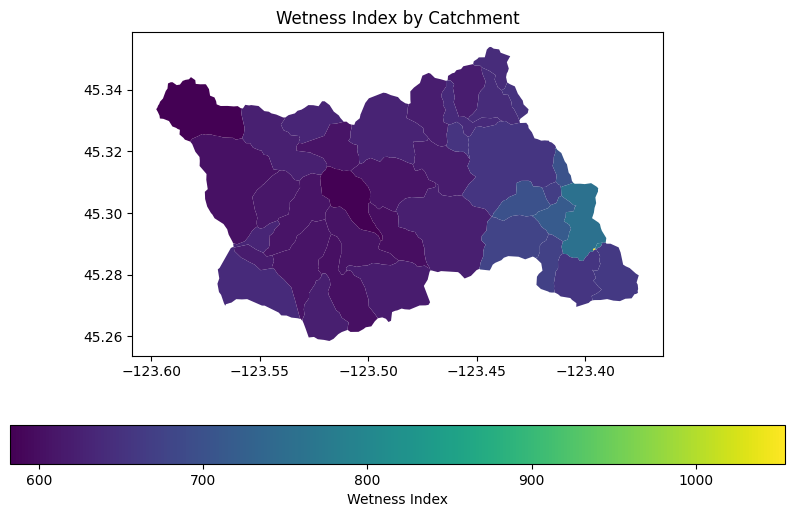

In [76]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
catchments.plot(column='wetindexcat', cmap='viridis', legend=True, ax=ax,
           legend_kwds={'label': "Wetness Index",
                        'orientation': "horizontal"})
ax.set_title("Wetness Index by Catchment")
plt.show()

In [3]:
import matplotlib
soil = xr.open_dataset('C:/Users/mweber/GitProjects/hysetter/data/nestucca/soil/gnatsgo_geom_0.nc')
soil

<xarray.Dataset> Size: 15MB
Dimensions:      (y: 1221, x: 1500)
Coordinates:
  * x            (x) float64 12kB -2.132e+06 -2.132e+06 ... -2.117e+06
  * y            (y) float64 10kB 2.795e+06 2.795e+06 ... 2.783e+06 2.783e+06
Data variables:
    tk0_999a     (y, x) float32 7MB ...
    aws0_999     (y, x) float32 7MB ...
    spatial_ref  int64 8B ...

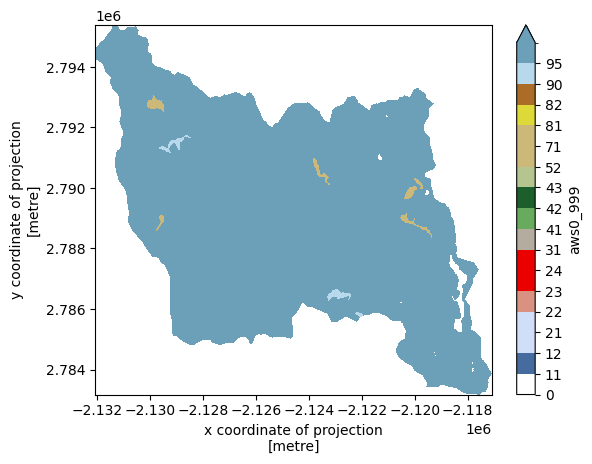

In [4]:
cmap, norm, levels = gh.cover_legends()
cover = soil.aws0_999
_ = cover.plot.imshow(cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})

In [38]:
gcx = GeoConnex(dev=False)
print("\n".join(f"{n}: {e.description}" for n, e in gcx.endpoints.items()))

hu02: Two-digit Hydrologic Regions from USGS NHDPlus High Resolution
hu04: Four-digit Hydrologic Subregion from USGS NHDPlus High Resolution
hu06: Six-digit Hydrologic Basins from USGS NHDPlus High Resolution
hu08: Eight-digit Hydrologic Subbasins from USGS NHDPlus High Resolution
hu10: Ten-digit Watersheds from USGS NHDPlus High Resolution
nat_aq: National Aquifers of the United States from USGS National Water Information System National Aquifer code list
principal_aq: Principal Aquifers of the United States from 2003 USGS data release
sec_hydrg_reg: Secondary Hydrogeologic Regions of the Conterminous United States from 2018 USGS data release
gages: United States Community Contributed Reference Stream Gages
mainstems: United States Community Contributed Reference Mainstem Rivers
dams: United States Community Contributed Reference Dams
pws: Public Water Systems from United States EPA Safe Drinking Water Information System
states: States from United States Census Bureau Cartographic Bou

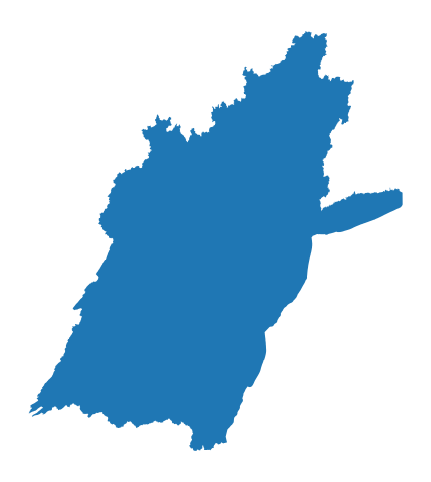

In [47]:
gcx.item = "hu02"
gcx
h2 = gcx.byitem("02")
ax = h2.plot(figsize=(6, 6))
ax.set_axis_off()

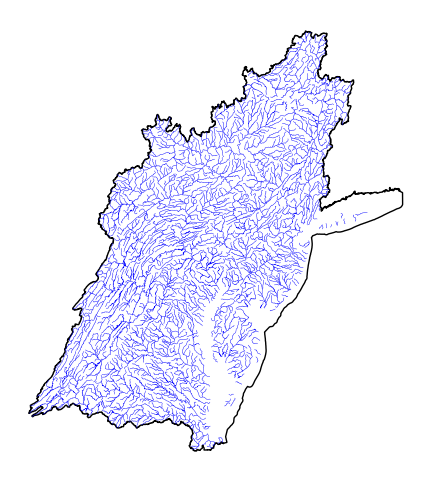

In [48]:
gcx.item = "mainstems"
ms = gcx.bygeometry(h2.to_crs(4326).union_all(), predicate="within")
ax = h2.plot(figsize=(6, 6), facecolor="none", edgecolor="k")
ms.plot(ax=ax, color="b", lw=0.3)
ax.set_axis_off()

In [50]:
nestucca

,SITE_ID,COMID,WSAREASQKM,PERM_ID,NHDPlusHR_WSAREASQKM,UNIQUE_ID,geometry
0,NRS23_OR_10186,23875713,98.394906,165016198,98.4046,NRS_OR-10791,"MULTIPOLYGON (((-123.59765 45.33363, -123.5976..."
